The code implements a financial reinforcement learning agent using Q-learning.

It utilizes a neural network to approximate Q-value functions.
Exploration-exploitation balance is achieved through epsilon-greedy strategy.

Experience replay enhances learning efficiency.

Validation is employed for performance evaluation and overfitting prevention.

## Import necessary libraries

In [2]:
import os
import math
import random
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(precision=4, suppress=True)
os.environ['PYTHONHASHSEED'] = '0'
%config InlineBackend.figure_format = 'svg'

<ipython-input-2-eabaf03f8e47>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
import warnings as w
w.simplefilter('ignore')

# Improved Finance Environment

Data Loading and Preparation:
    
* Fetches financial data from a URL.
* Calculates returns, rolling mean, standard deviation, and a target direction signal (d).
* Normalizes data for consistent scaling.

State Representation (get_state):

* Provides a sequence of past feature values for decision-making.

Action Choice (step):

* Takes an action (0 or 1) representing a prediction of direction.
* Calculates rewards based on prediction accuracy and return.
* Defines conditions for episode termination (end of data, incorrect prediction, or performance below a threshold).
* Returns the next state, reward, termination flag, and additional information.

In [4]:
class observation_space:
    def __init__(self, n):
        self.shape = (n,)

In [5]:
class action_space:
    def __init__(self, n):
        self.n = n
    def seed(self, seed):
        pass
    def sample(self):
        return random.randint(0, self.n - 1)

In [6]:
class Finance:
    url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'
    def __init__(self, symbol, features, window, lags,
                 leverage=1, min_performance=0.85,
                 start=0, end=None, mu=None, std=None):
        self.symbol = symbol
        self.features = features
        self.n_features = len(features)
        self.window = window
        self.lags = lags
        self.leverage = leverage
        self.min_performance = min_performance
        self.start = start
        self.end = end
        self.mu = mu
        self.std = std
        self.observation_space = observation_space(self.lags)
        self.action_space = action_space(2)
        self._get_data()
        self._prepare_data()
    def _get_data(self):
        self.raw = pd.read_csv(self.url, index_col=0,
                               parse_dates=True).dropna()
    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol])
        self.data = self.data.iloc[self.start:]
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        self.data['s'] = self.data[self.symbol].rolling(
                                              self.window).mean()
        self.data['m'] = self.data['r'].rolling(self.window).mean()
        self.data['v'] = self.data['r'].rolling(self.window).std()
        self.data.dropna(inplace=True)
        if self.mu is None:
            self.mu = self.data.mean()
            self.std = self.data.std()
        self.data_ = (self.data - self.mu) / self.std
        self.data_['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data_['d'] = self.data_['d'].astype(int)
        if self.end is not None:
            self.data = self.data.iloc[:self.end - self.start]
            self.data_ = self.data_.iloc[:self.end - self.start]
    def _get_state(self):
        return self.data_[self.features].iloc[self.bar -
                                self.lags:self.bar]
    def seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.performance = 1
        self.bar = self.lags
        state = self.data_[self.features].iloc[self.bar-
                        self.lags:self.bar]
        return state.values
    def step(self, action):
        correct = action == self.data_['d'].iloc[self.bar]
        ret = self.data['r'].iloc[self.bar] * self.leverage
        reward_1 = 1 if correct else 0
        reward_2 = abs(ret) if correct else -abs(ret)
        self.treward += reward_1
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.lags)
        self.performance *= math.exp(reward_2)
        if self.bar >= len(self.data):
            done = True
        elif reward_1 == 1:
            done = False
        elif (self.performance < self.min_performance and
              self.bar > self.lags + 15):
            done = True
        else:
            done = False
        state = self._get_state()
        info = {}
        return state.values, reward_1 + reward_2 * 252, done, info

In [7]:
env = Finance('EUR=', ['EUR=', 'r', 'm'], 10, 5)

In [8]:
a = env.action_space.sample()
a

1

In [10]:
env.reset()

array([[ 1.7721, -1.0214, -0.3939],
       [ 1.5973, -2.4432, -1.0212],
       [ 1.5876, -0.1208, -1.2423],
       [ 1.6292,  0.6083, -0.6734],
       [ 1.6408,  0.1807, -0.9975]])

In [11]:
env.step(a)

(array([[ 1.5973, -2.4432, -1.0212],
        [ 1.5876, -0.1208, -1.2423],
        [ 1.6292,  0.6083, -0.6734],
        [ 1.6408,  0.1807, -0.9975],
        [ 1.5725, -0.9502, -1.7143]]),
 -1.3750521308536245,
 False,
 {})

# Improved Financial QL Agent

Model Construction (_build_model
):

* Creates a multi-layer perceptron (MLP) neural network for Q-value estimation.

Action Selection (act):

* Explores by taking a random action with probability epsilon.
* Otherwise, exploits by choosing the action with the highest predicted Q-value.

Learning (replay):

* Iterates through a batch of stored experiences.
* Updates Q-value estimates for actions using the Bellman equation.
* Gradually reduces epsilon for a balance of exploration and exploitation.

Training (learn):

* Runs multiple episodes:
    * Resets the environment for a new episode.
    * Interacts with the environment for a maximum of 10000 steps.
    * Stores experiences in memory.
    * Periodically updates the model (replay).
    * Validates performance on a separate dataset.

* Validation (validate):
    * Evaluates the agent's performance on unseen data without exploration.



In [12]:
from collections import deque

In [13]:
from sklearn.neural_network import MLPRegressor

In [14]:
class FQLAgent:
    def __init__(self, hidden_layers, hidden_units, learning_rate,
                 learn_env, valid_env):
        self.learn_env = learn_env
        self.valid_env = valid_env
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.99
        self.learning_rate = learning_rate
        self.gamma = 0.95
        self.batch_size = 128
        self.max_treward = 0
        self.trewards = list()
        self.averages = list()
        self.performances = list()
        self.aperformances = list()
        self.vperformances = list()
        self.memory = deque(maxlen=2000)
        self.model = self._build_model(hidden_layers, hidden_units,
                                       learning_rate)

    def _build_model(self, hl, hu, lr):
        model = MLPRegressor(hidden_layer_sizes=hl * [hu],
                            solver='adam', learning_rate='constant',
                            learning_rate_init=lr,
                            random_state=100, max_iter=500,
                            warm_start=True
                            )
        model.fit(np.random.standard_normal((2, self.learn_env.lags *
                                             self.learn_env.n_features)),
                  np.random.standard_normal((2, 2)))
        return model
    def act(self, state):
        if random.random() <= self.epsilon:
            return self.learn_env.action_space.sample()
        action = self.model.predict(state.flatten().reshape(1, -1))[0]
        return np.argmax(action)

    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            if not done:
                reward += self.gamma * np.amax(
                    self.model.predict(next_state.flatten().reshape(1, -1))[0])
            target = self.model.predict(state.flatten().reshape(1, -1))
            target[0, action] = reward
            self.model.partial_fit(state.flatten().reshape(1, -1), target)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    def learn(self, episodes):
        for e in range(1, episodes + 1):
            state = self.learn_env.reset()
            state = np.reshape(state, [1, self.learn_env.lags,
                                       self.learn_env.n_features])
            for _ in range(10000):
                action = self.act(state)
                next_state, reward, done, info = \
                                self.learn_env.step(action)
                next_state = np.reshape(next_state,
                                [1, self.learn_env.lags,
                                 self.learn_env.n_features])
                self.memory.append([state, action, reward,
                                     next_state, done])
                state = next_state
                if done:
                    treward = _ + 1
                    self.trewards.append(treward)
                    av = sum(self.trewards[-25:]) / 25
                    perf = self.learn_env.performance
                    self.averages.append(av)
                    self.performances.append(perf)
                    self.aperformances.append(
                        sum(self.performances[-25:]) / 25)
                    self.max_treward = max(self.max_treward, treward)
                    templ = 'episode: {:2d}/{} | treward: {:4d} | '
                    templ += 'perf: {:5.3f} | av: {:5.1f} | max: {:4d}'
                    print(templ.format(e, episodes, treward, perf,
                                  av, self.max_treward), end='\r')
                    break
            self.validate(e, episodes)
            if len(self.memory) > self.batch_size:
                self.replay()
        print()
    def validate(self, e, episodes):
        state = self.valid_env.reset()
        for _ in range(10000):
            action = np.argmax(self.model.predict(state.flatten().reshape(1, -1))[0])
            next_state, reward, done, info = self.valid_env.step(action)
            state = np.reshape(next_state, [self.valid_env.lags,
                                   self.valid_env.n_features])
            if done:
                treward = _ + 1
                perf = self.valid_env.performance
                self.vperformances.append(perf)
                if e % 20 == 0:
                    templ = 71 * '='
                    templ += '\nepisode: {:2d}/{} | VALIDATION | '
                    templ += 'treward: {:4d} | perf: {:5.3f} | '
                    templ += 'eps: {:.2f}\n'
                    templ += 71 * '='
                    print(templ.format(e, episodes, treward,
                                       perf, self.epsilon))
                break

Data and Agent Configuration:
* Sets symbol, features, window and lag for data processing.
* Creates training and validation environments with appropriate data splits.
* Initializes the agent with hyperparameters.

Training Loop:
* Runs the learning process for a specified number of episodes.

Visualization:
* Plots moving average of total reward and regression line to visualize learning progress.
* Plots gross performance on training and validation sets along with regression lines to assess generalization.

In [15]:
symbol = 'EUR='
features = ['r', 's', 'm', 'v']

In [16]:
a = 0
b = 2000
c = 500

In [17]:
learn_env = Finance(symbol, features, window=10, lags=6,
                 leverage=1, min_performance=0.85,
                 start=a, end=a + b, mu=None, std=None)

In [18]:
learn_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2000 entries, 2010-01-19 to 2017-12-26
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    2000 non-null   float64
 1   r       2000 non-null   float64
 2   s       2000 non-null   float64
 3   m       2000 non-null   float64
 4   v       2000 non-null   float64
dtypes: float64(5)
memory usage: 93.8 KB


In [19]:
valid_env = Finance(symbol, features, window=learn_env.window,
                 lags=learn_env.lags, leverage=learn_env.leverage,
                 min_performance=learn_env.min_performance,
                 start=a + b, end=a + b + c,
                 mu=learn_env.mu, std=learn_env.std)

In [20]:
valid_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2017-12-27 to 2019-12-20
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    500 non-null    float64
 1   r       500 non-null    float64
 2   s       500 non-null    float64
 3   m       500 non-null    float64
 4   v       500 non-null    float64
dtypes: float64(5)
memory usage: 23.4 KB


In [21]:
agent = FQLAgent(2, 24, 0.0001, learn_env, valid_env)

In [22]:
episodes = 61

In [23]:
%time agent.learn(episodes)

episode: 20/61 | VALIDATION | treward:  494 | perf: 1.021 | eps: 0.83
episode: 40/61 | VALIDATION | treward:  494 | perf: 1.013 | eps: 0.68
episode: 60/61 | VALIDATION | treward:  494 | perf: 1.020 | eps: 0.55

CPU times: user 2min 12s, sys: 3.32 s, total: 2min 15s
Wall time: 2min 23s


In [24]:
agent.epsilon

0.5416850759668536

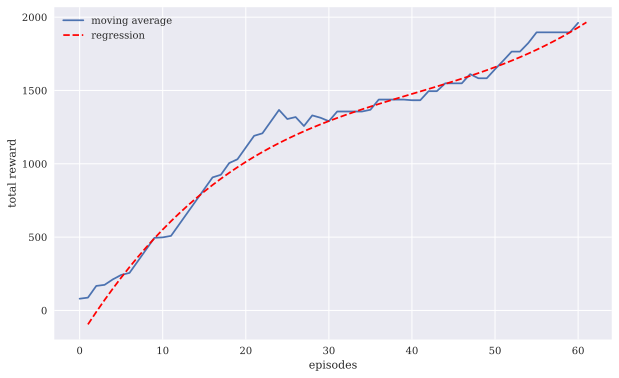

In [25]:
plt.figure(figsize=(10, 6))
x = range(1, len(agent.averages) + 1)
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='moving average')
plt.plot(x, y, 'r--', label='regression')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend();

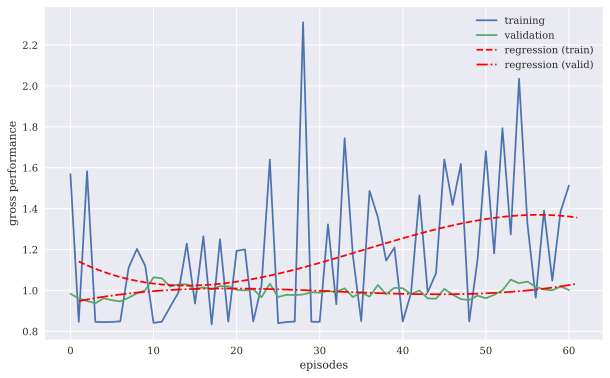

In [26]:
plt.figure(figsize=(10, 6))
x = range(1, len(agent.performances) + 1)
y = np.polyval(np.polyfit(x, agent.performances, deg=3), x)
y_ = np.polyval(np.polyfit(x, agent.vperformances, deg=3), x)
plt.plot(agent.performances[:], label='training')
plt.plot(agent.vperformances[:], label='validation')
plt.plot(x, y, 'r--', label='regression (train)')
plt.plot(x, y_, 'r-.', label='regression (valid)')
plt.xlabel('episodes')
plt.ylabel('gross performance')
plt.legend();